# Goal : predict total hourly charging demand (kwh) across all stations

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# pulling the parquets from s3 and loading into pandas dataframes

storage_options = {
    "client_kwargs": {"endpoint_url": "http://localhost:4566"},
    "key": "test",
    "secret": "test"
}
df = pd.read_parquet('s3://ev-data/processed/', 
                           storage_options=storage_options,
                           engine='pyarrow')
df.head()

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,hour
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,2018-12-21 11:00:00
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,2018-12-22 16:00:00
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,2018-12-24 22:00:00


# testing baseline models

In [7]:
hourly_total = (df.groupby('hour', as_index=True).agg(total_kwh=('el_kwh','sum'),n_sessions=('session_id','count'),avg_kwh=('el_kwh','mean')).sort_index())
print(hourly_total)

print(hourly_total.describe())
print(hourly_total.dtypes)

                     total_kwh  n_sessions    avg_kwh
hour                                                 
2018-12-21 10:00:00       1.17           2   0.585000
2018-12-21 11:00:00      29.87           1  29.870000
2018-12-22 16:00:00      15.56           1  15.560000
2018-12-24 22:00:00       3.62           1   3.620000
2018-12-24 23:00:00      16.14           1  16.140000
...                        ...         ...        ...
2020-01-31 16:00:00      12.96           3   4.320000
2020-01-31 17:00:00      24.91           3   8.303333
2020-01-31 18:00:00       9.10           1   9.100000
2020-01-31 19:00:00       6.59           2   3.295000
2020-01-31 20:00:00      20.14           1  20.140000

[3338 rows x 3 columns]
         total_kwh   n_sessions      avg_kwh
count  3338.000000  3338.000000  3338.000000
mean     26.095737     2.050330    13.019135
std      26.172955     1.656395     9.591747
min       0.010000     1.000000     0.010000
25%       8.940000     1.000000     6.700000
50%

In [14]:
dfh = hourly_total.copy()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

In [20]:
dfh['hour_of_day'] = dfh.index.hour
dfh['day_of_week'] = dfh.index.dayofweek
dfh['month'] = dfh.index.month
dfh

,total_kwh,n_sessions,avg_kwh,hour_of_day,day_of_week,month
hour,,,,,,
2018-12-21 10:00:00,1.17,2,0.585000,10,4,12
2018-12-21 11:00:00,29.87,1,29.870000,11,4,12
2018-12-22 16:00:00,15.56,1,15.560000,16,5,12
2018-12-24 22:00:00,3.62,1,3.620000,22,0,12
2018-12-24 23:00:00,16.14,1,16.140000,23,0,12
...,...,...,...,...,...,...
2020-01-31 16:00:00,12.96,3,4.320000,16,4,1
2020-01-31 17:00:00,24.91,3,8.303333,17,4,1
2020-01-31 18:00:00,9.10,1,9.100000,18,4,1


In [21]:
x=dfh[['n_sessions', 'avg_kwh', 'hour_of_day', 'day_of_week', 'month']]
y=dfh['total_kwh']

# time based split
split_date = dfh.index[-24*30]
x_train = x[dfh.index < split_date]
x_test = x[dfh.index >= split_date]
y_train = y[dfh.index < split_date]
y_test = y[dfh.index >= split_date]

print(f"train/test sizes : {x_train.shape} / {x_test.shape}")

train/test sizes : (2618, 5) / (720, 5)


In [22]:
lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
dt = DecisionTreeRegressor(random_state=42,max_depth=5)
xgb = XGBRegressor(n_estimators=100, verbosity=0, random_state=42, max_depth=5)

In [25]:
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
xgb.fit(x_train, y_train)

preds_lr = lr.predict(x_test)
preds_dt = dt.predict(x_test)
preds_xgb = xgb.predict(x_test)

mae_lr = mean_absolute_error(y_test, preds_lr)
mse_lr = root_mean_squared_error(y_test, preds_lr)
mae_dt = mean_absolute_error(y_test, preds_dt)
mse_dt = root_mean_squared_error(y_test, preds_dt)
mae_xgb = mean_absolute_error(y_test, preds_xgb)
mse_xgb = root_mean_squared_error(y_test, preds_xgb)

print(f"LR MAE: {mae_lr}, RMSE: {mse_lr}")
print(f"DT MAE: {mae_dt}, RMSE: {mse_dt}")
print(f"XGB MAE: {mae_xgb}, RMSE: {mse_xgb}")

LR MAE: 8.34918122032614, RMSE: 12.907141792805492
DT MAE: 5.4389392379355845, RMSE: 10.062514787008174
XGB MAE: 1.4227493071382247, RMSE: 4.2905785657725275


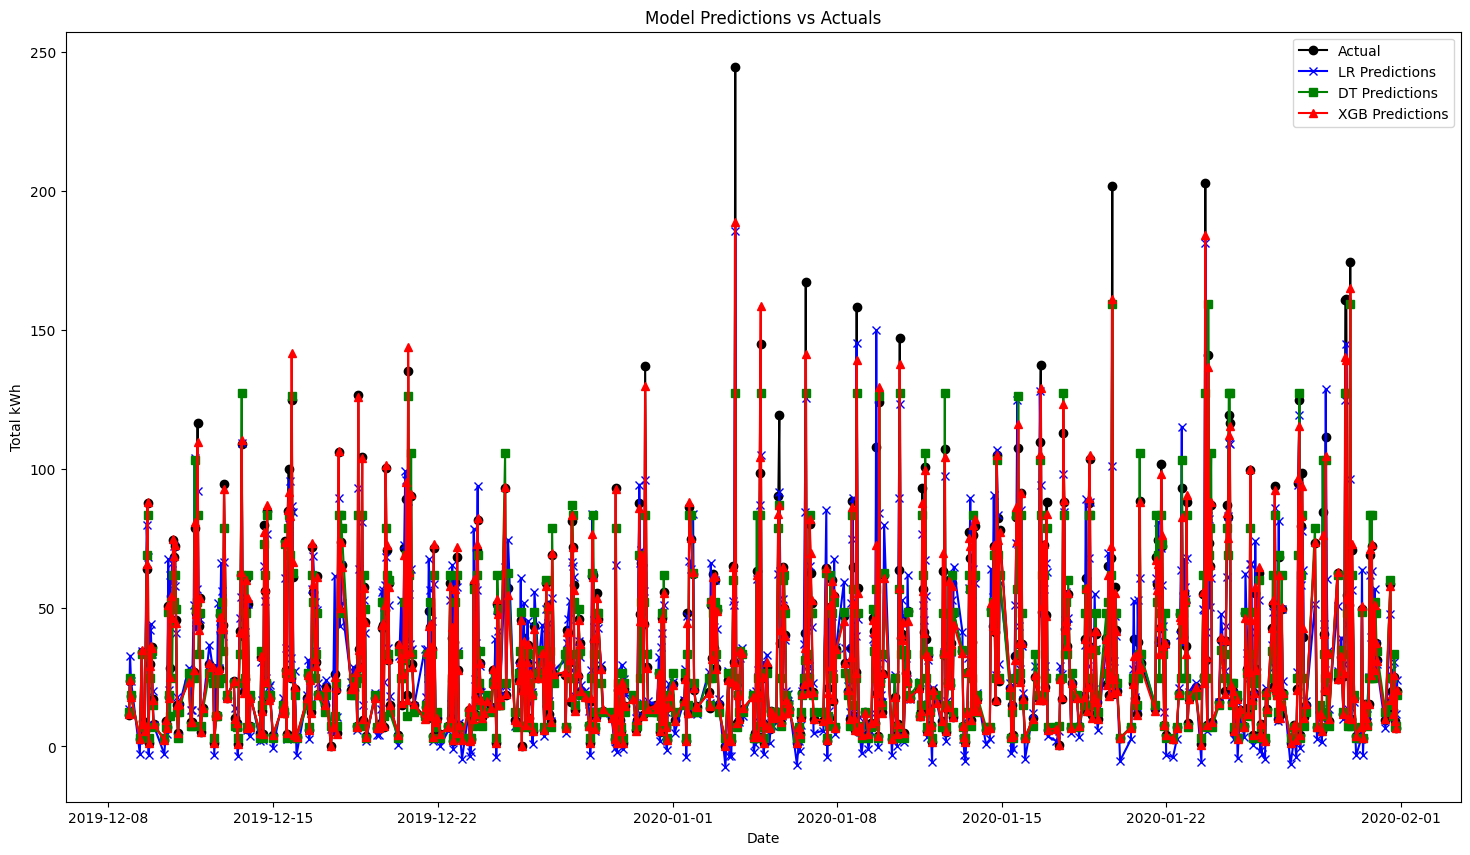

In [32]:
plt.figure(figsize=(18,10))
plt.plot(y_test.index, y_test, label='Actual', marker='o', color='black')
plt.plot(y_test.index, preds_lr, label='LR Predictions', marker='x', color='blue')
plt.plot(y_test.index, preds_dt, label='DT Predictions', marker='s', color='green')
plt.plot(y_test.index, preds_xgb, label='XGB Predictions', marker='^', color='red')
plt.xlabel('Date')
plt.ylabel('Total kWh')
plt.title('Model Predictions vs Actuals')
plt.legend()
plt.show()


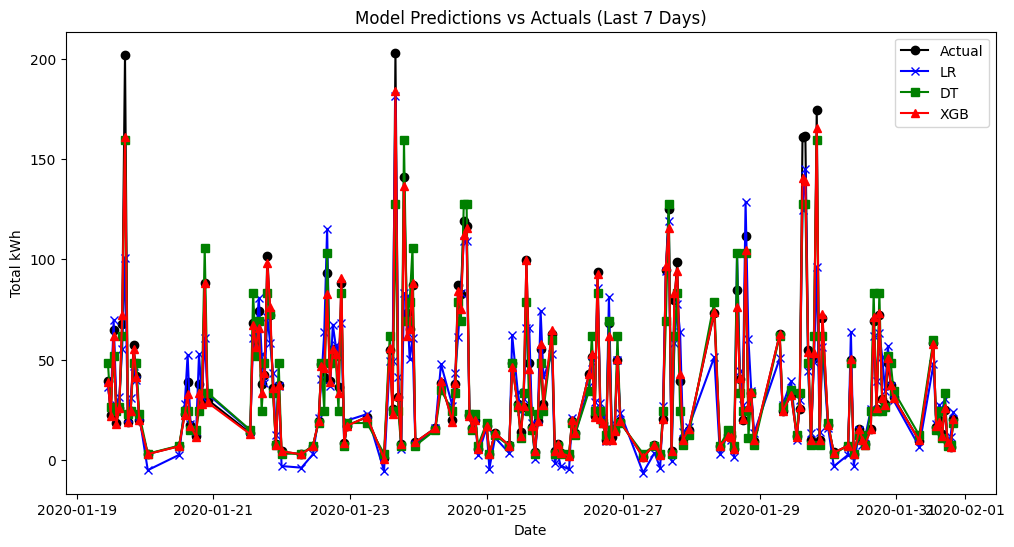

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test[-24*7:], label='Actual', marker='o', color='black')
plt.plot(pd.Series(preds_lr, index=y_test.index)[-24*7:], label='LR', marker='x', color='blue')
plt.plot(pd.Series(preds_dt, index=y_test.index)[-24*7:], label='DT', marker='s', color='green')
plt.plot(pd.Series(preds_xgb, index=y_test.index)[-24*7:], label='XGB', marker='^', color='red')
plt.xlabel('Date')
plt.ylabel('Total kWh')
plt.title('Model Predictions vs Actuals (Last 7 Days)')
plt.legend()
plt.show()

In [10]:
print(df.dtypes)
print(hourly_total.dtypes)

session_id                    int64
garage_id                    object
user_id                      object
user_type                  category
shared_id                  category
start_plugin         datetime64[ns]
start_plugin_hour             int64
end_plugout          datetime64[ns]
end_plugout_hour              int64
el_kwh                      float64
duration_hours              float64
month_plugin               category
weekdays_plugin            category
plugin_category            category
duration_category          category
hour                 datetime64[ns]
dtype: object
total_kwh     float64
n_sessions      int64
avg_kwh       float64
dtype: object


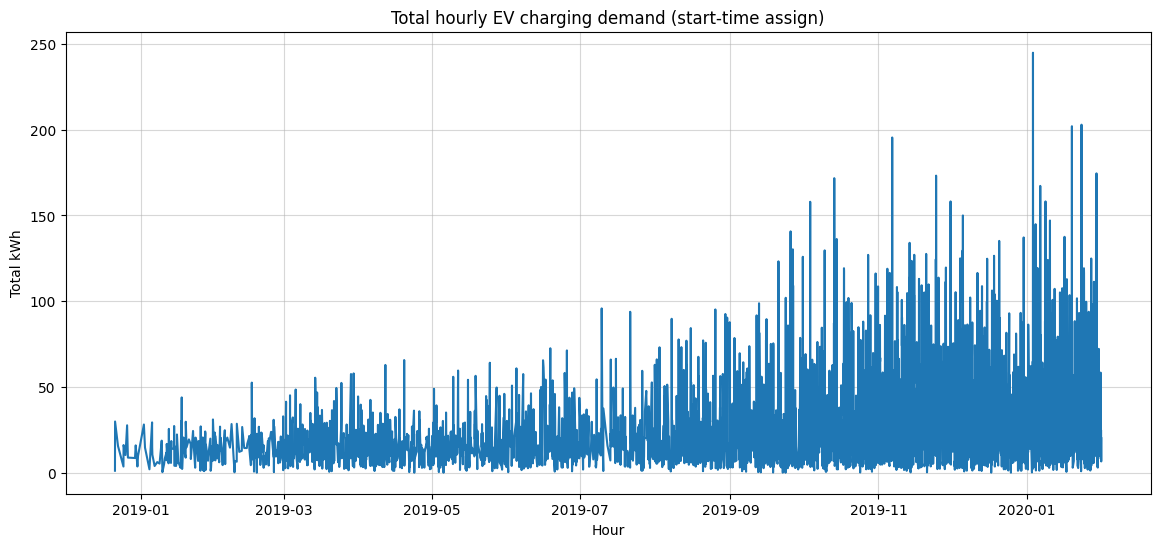

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(hourly_total.index, hourly_total['total_kwh'])
plt.title('Total hourly EV charging demand (start-time assign)')
plt.xlabel('Hour')
plt.ylabel('Total kWh')
plt.grid(True, alpha=0.5)
plt.show()

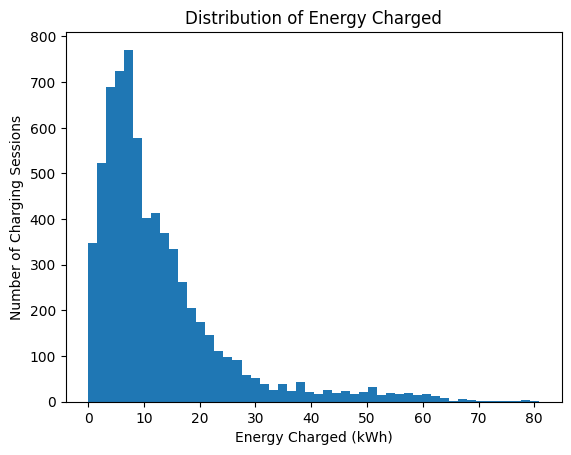

In [12]:
plt.hist(df['el_kwh'], bins=50)
plt.xlabel('Energy Charged (kWh)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Energy Charged')
plt.show()

In [13]:
'''
df["el_kwh"] = np.log1p(df["el_kwh"].fillna(0).astype(float))
plt.hist(df['el_kwh'], bins=50)
plt.xlabel('Energy Charged (kWh)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Energy Charged')
plt.show()
print(df['el_kwh'].skew() )'''

'\ndf["el_kwh"] = np.log1p(df["el_kwh"].fillna(0).astype(float))\nplt.hist(df[\'el_kwh\'], bins=50)\nplt.xlabel(\'Energy Charged (kWh)\')\nplt.ylabel(\'Number of Charging Sessions\')\nplt.title(\'Distribution of Energy Charged\')\nplt.show()\nprint(df[\'el_kwh\'].skew() )'

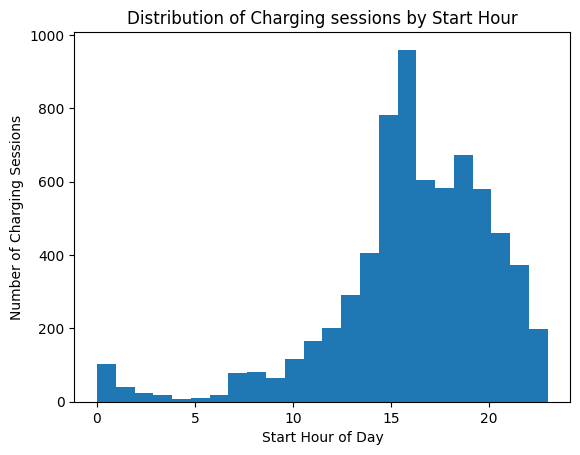

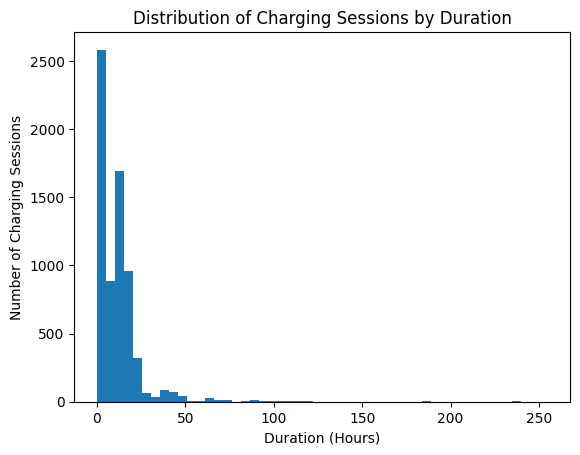

In [14]:

plt.hist(df['start_plugin_hour'], bins=24)
plt.xlabel('Start Hour of Day')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging sessions by Start Hour')
plt.show()
plt.hist(df['duration_hours'], bins=50)
plt.xlabel('Duration (Hours)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging Sessions by Duration')
plt.show()

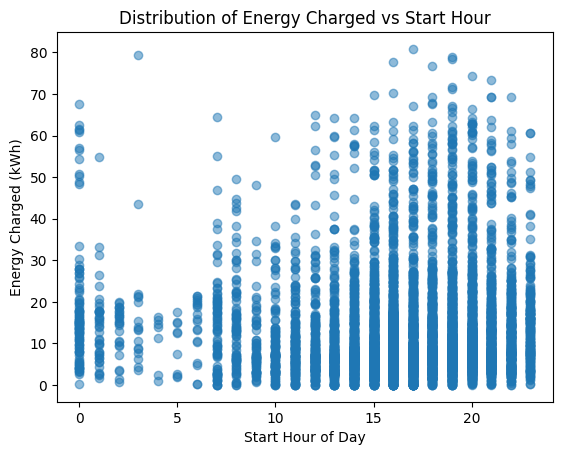

In [15]:

plt.scatter(df['start_plugin_hour'], df['el_kwh'], alpha=0.5)
plt.xlabel('Start Hour of Day')
plt.ylabel('Energy Charged (kWh)')
plt.title('Distribution of Energy Charged vs Start Hour')
plt.show()

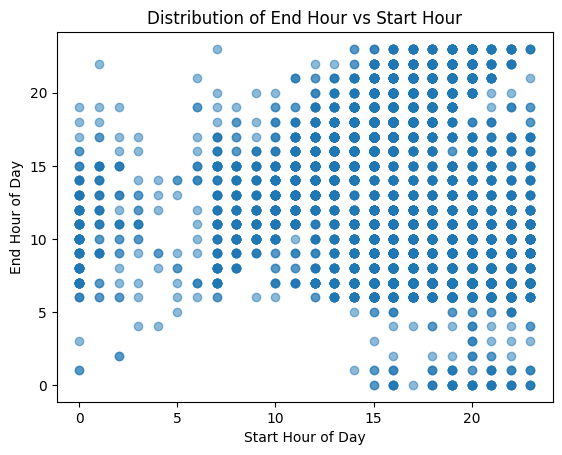

In [16]:

plt.scatter(df['start_plugin_hour'], df['end_plugout_hour'], alpha=0.5)
plt.xlabel('Start Hour of Day')
plt.ylabel('End Hour of Day')
plt.title('Distribution of End Hour vs Start Hour')
plt.show()

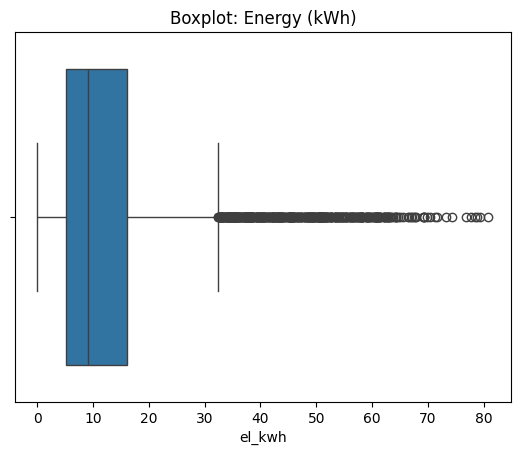

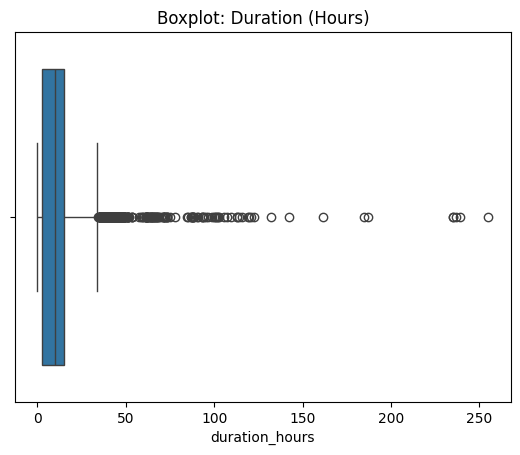

In [17]:
sns.boxplot(x=df['el_kwh'].dropna())
plt.title('Boxplot: Energy (kWh)')
plt.show()
sns.boxplot(x=df['duration_hours'].dropna())
plt.title('Boxplot: Duration (Hours)')
plt.show()

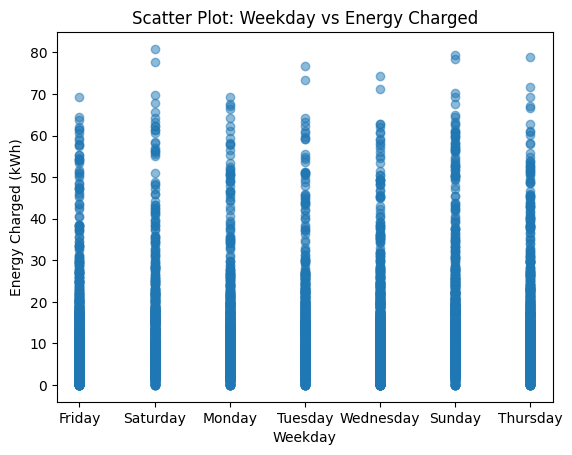

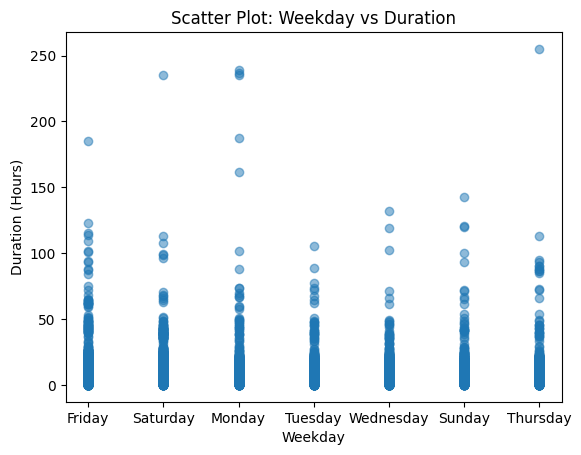

In [18]:
plt.scatter(df['weekdays_plugin'], df['el_kwh'], alpha=0.5)
plt.xlabel('Weekday')
plt.ylabel('Energy Charged (kWh)')
plt.title('Scatter Plot: Weekday vs Energy Charged')
plt.show()
plt.scatter(df['weekdays_plugin'], df['duration_hours'], alpha=0.5)
plt.xlabel('Weekday')
plt.ylabel('Duration (Hours)')
plt.title('Scatter Plot: Weekday vs Duration')
plt.show()

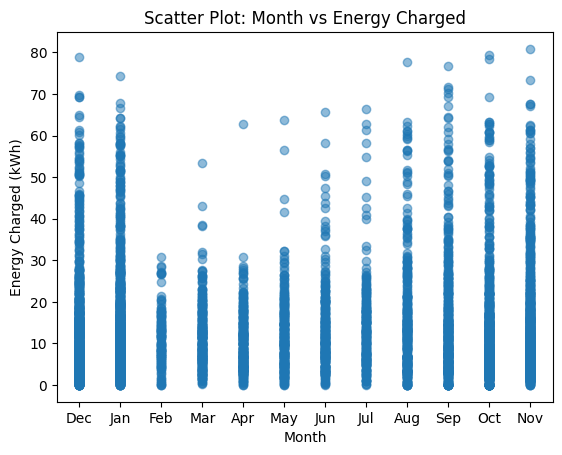

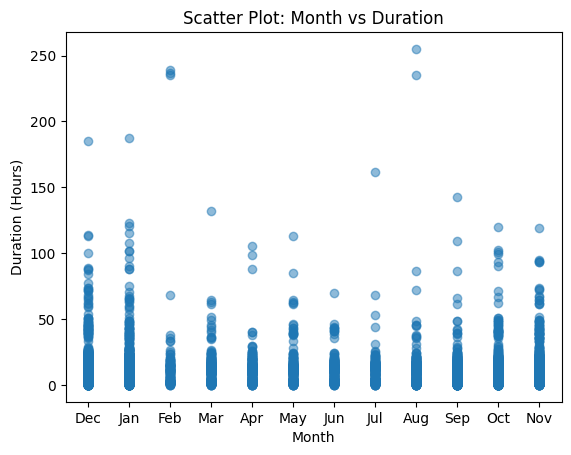

In [19]:
plt.scatter(df['month_plugin'], df['el_kwh'], alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Energy Charged (kWh)')
plt.title('Scatter Plot: Month vs Energy Charged')
plt.show()
plt.scatter(df['month_plugin'], df['duration_hours'], alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Duration (Hours)')
plt.title('Scatter Plot: Month vs Duration')
plt.show()

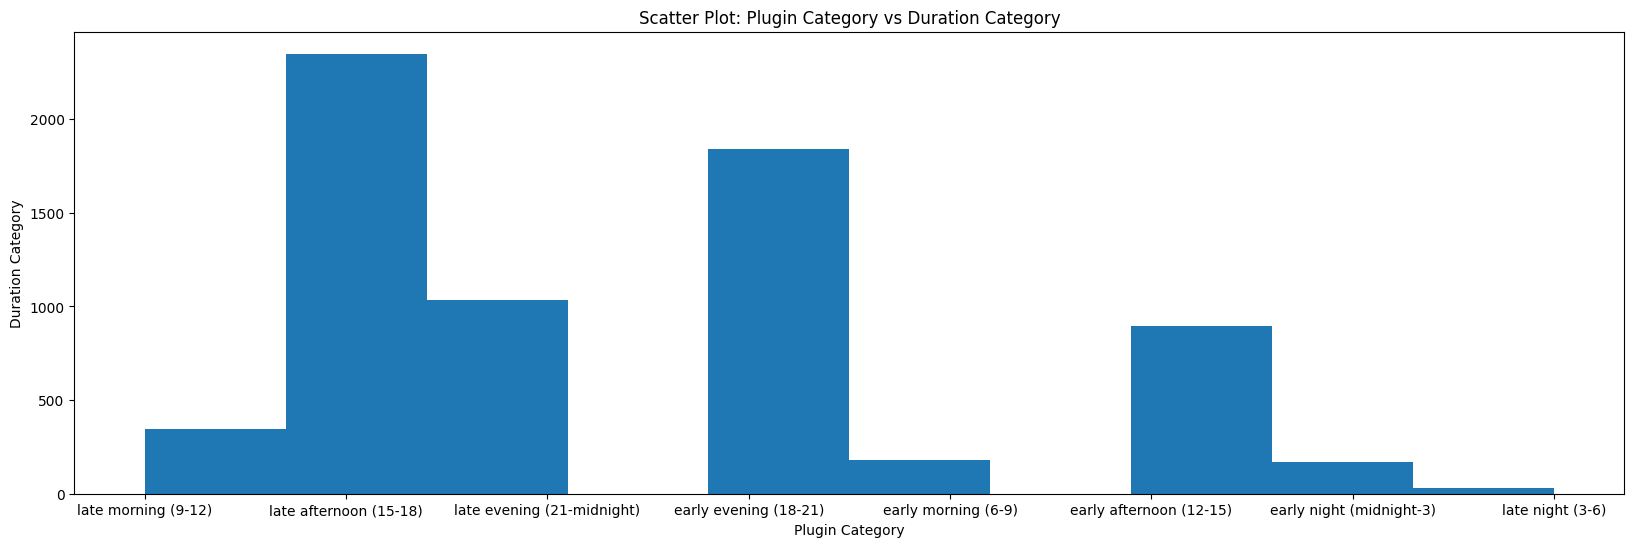

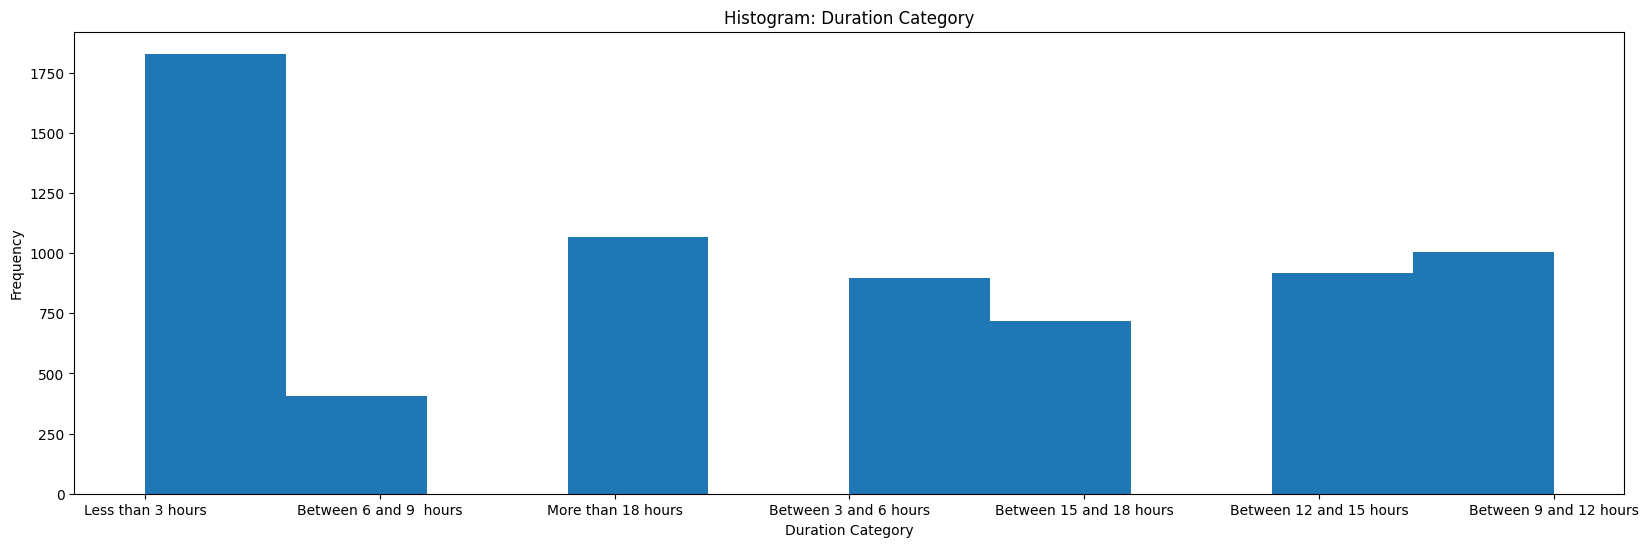

In [20]:
plt.figure(figsize=(20,6))
plt.hist(df['plugin_category'])
plt.xlabel('Plugin Category')
plt.ylabel('Duration Category')
plt.title('Scatter Plot: Plugin Category vs Duration Category')
plt.show()
plt.figure(figsize=(20,6))
plt.hist(df['duration_category'])
plt.xlabel('Duration Category')
plt.ylabel('Frequency')
plt.title('Histogram: Duration Category')
plt.show()


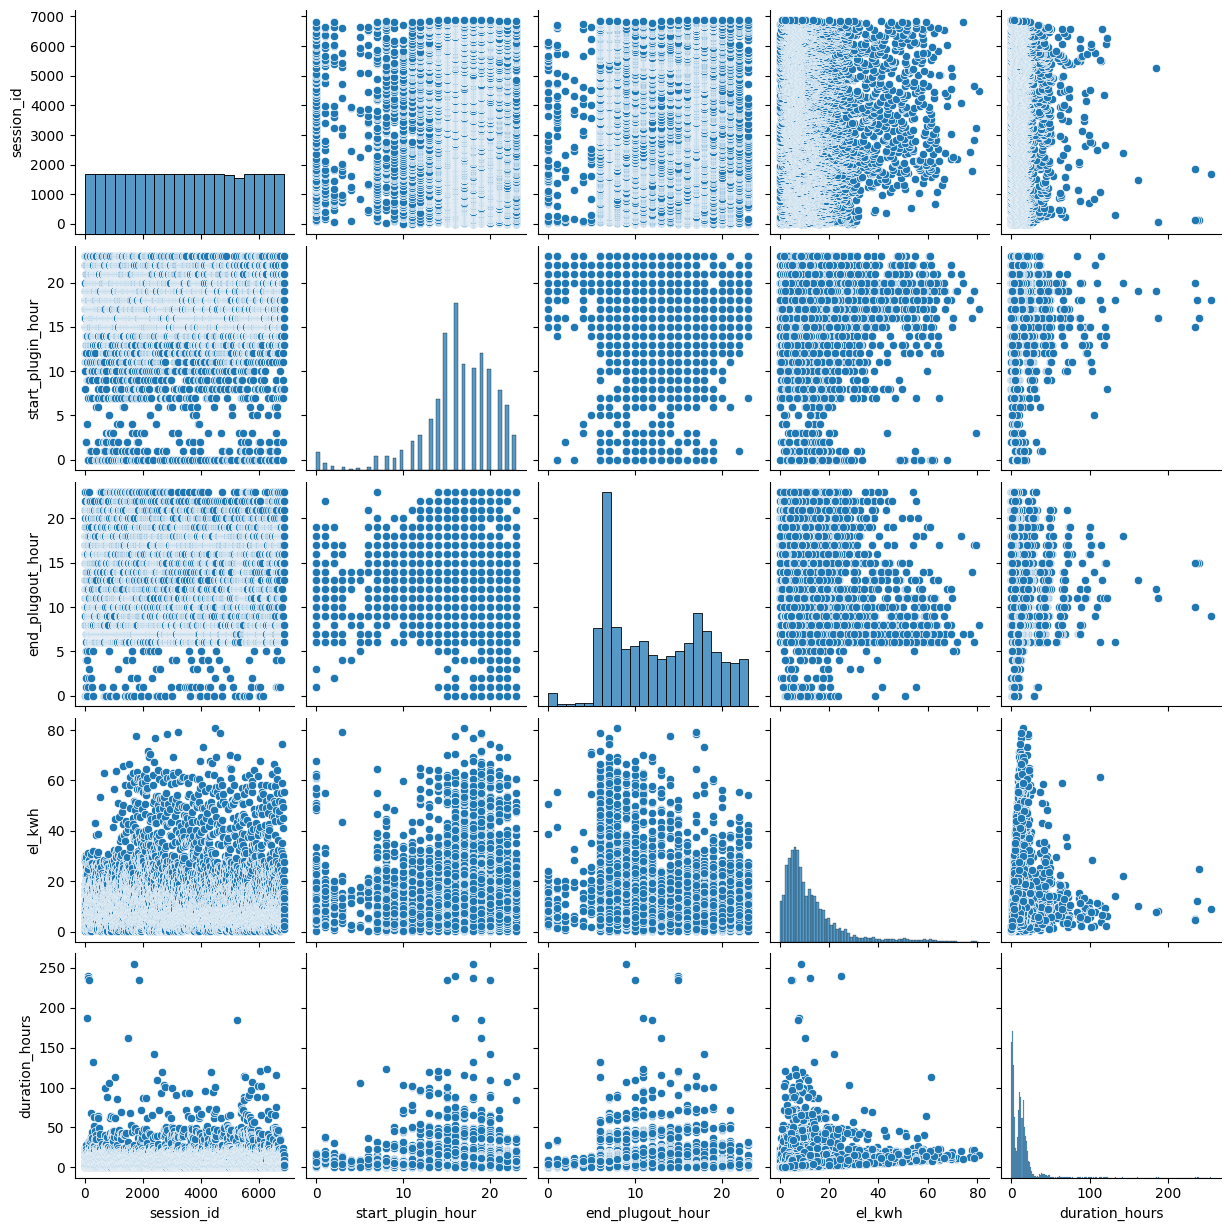

In [21]:
sns.pairplot(df)
plt.show()

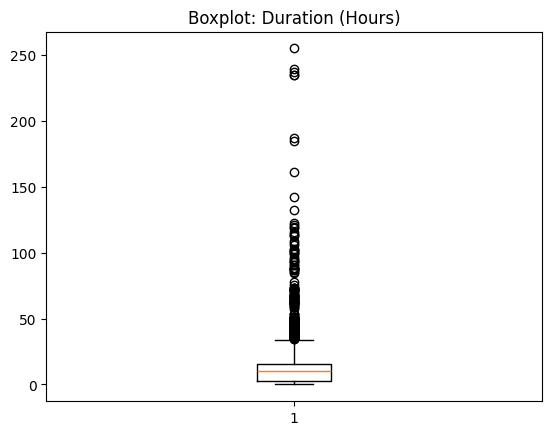

In [22]:
plt.boxplot(df['duration_hours'])
plt.title('Boxplot: Duration (Hours)')
plt.show()